In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D, concatenate, BatchNormalization, Conv2DTranspose



In [14]:
#read dataset

hf = h5py.File('E:/Technische Universität Berlin/Master Luft- und Raumfahrttechnik/4. Semester/Machine Learning for Dynamical Systems/Project2/Project2/Data/ML_WORKSHOP_Kolmogorov_Re40_T500_DT001.h5','r')

learnrate = 0.0001
Nx = 48 # Nx=24 for Re=20 or Re=30; Nx=48 for Re=40
Nu = 2
t = np.array(hf.get('t'))
u_all = np.zeros((Nx,Nx,len(t),Nu))
u_all[:,:,:,0] = np.array(hf.get('u_refined'))
#if Nu==2:
u_all[:,:,:,1] = np.array(hf.get('v_refined'))
u_all = np.transpose(u_all,[2,0,1,3])
#hf.close()
print(u_all.shape)

(5000, 48, 48, 2)


In [15]:
#choosing a test data set to assess the accuracy of our model
Ntrain = int(np.round(0.9*len(u_all)))
print(Ntrain)
u_all_train=u_all[:Ntrain,:,:,:]
print(u_all_train.shape)
u_all_test=u_all[Ntrain:,:,:,:]

4500
(4500, 48, 48, 2)


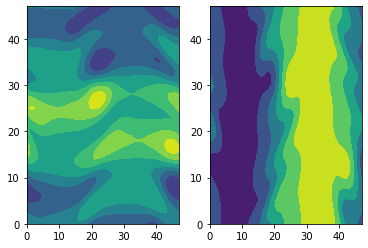

In [33]:
# visualization of the dataset
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all[0,:,:,1])

In [26]:
input_layer = tf.keras.Input(shape=(Nx, Nx, 2))

# Defining the encoder

x=tf.keras.layers.Conv2D(15,(3,3),activation='relu')(input_layer)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(10,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2D(5,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)


encoded=tf.keras.layers.Conv2D(5,(3,3),activation='relu')(x)



#reshaping the output data

#x=tf.keras.layers.Flatten()(encoded)
#x=tf.keras.layers.Dense(50,activation='relu')(x)
#x=tf.keras.layers.BatchNormalization()(x)
#x=tf.keras.layers.Dense(32,activation='relu')(x)
#x=tf.keras.layers.BatchNormalization()(x)
#reshaped=tf.keras.layers.Reshape((4,4,2))(x)

# defining the decoder


x=tf.keras.layers.Conv2DTranspose(5,(3,3),activation='relu')(encoded)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(10,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
#x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(15,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.UpSampling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Conv2DTranspose(15,(3,3),activation='relu')(x)
x=tf.keras.layers.BatchNormalization()(x)

decoded=tf.keras.layers.Conv2DTranspose(2,(3,3),activation='linear')(x)



# defining the autoencoder

autoencoder=tf.keras.Model(input_layer,decoded)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 48, 48, 2)]       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 46, 46, 15)        285       
                                                                 
 batch_normalization_57 (Bat  (None, 46, 46, 15)       60        
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 46, 46, 15)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 15)       0         
 g2D)                                                            
                                                                 
 batch_normalization_58 (Bat  (None, 23, 23, 15)       60  

In [27]:
# We use the adam optimizer for our first prediction

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learnrate),loss='mse')

In [28]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss', 
    mode='min',
    save_best_only=True)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001, patience=100, mode='min', verbose=1,restore_best_weights=True )

In [29]:
hist = autoencoder.fit(u_all_train,u_all_train,batch_size=10,epochs=200,validation_split=0.25, callbacks=[early_stop_callback])
loss_history = hist.history['loss']

Epoch 1/200
338/338 [==============================] - 8s 19ms/step - loss: 0.3240 - val_loss: 0.0667
Epoch 2/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0768 - val_loss: 0.0653
Epoch 3/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0563 - val_loss: 0.0587
Epoch 4/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0482 - val_loss: 0.0529
Epoch 5/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0428 - val_loss: 0.0496
Epoch 6/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0383 - val_loss: 0.0466
Epoch 7/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0341 - val_loss: 0.0442
Epoch 8/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0308 - val_loss: 0.0426
Epoch 9/200
338/338 [==============================] - 6s 19ms/step - loss: 0.0284 - val_loss: 0.0410
Epoch 10/200
338/338 [==============================] - 6s 19ms/step - loss: 0.026

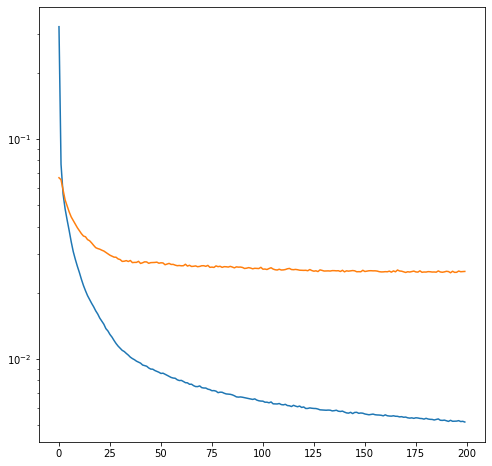

In [30]:
# we evaluate the loss for this model
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8,8))
plt.semilogy(loss, label= "training loss")
plt.semilogy(val_loss, label= "validation loss") 


16/16 [==============================] - 0s 14ms/step


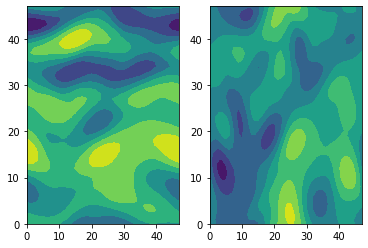

In [31]:
reconstructed_images=autoencoder.predict(u_all_test[:,:])
# visualization of the results
%matplotlib notebook
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(u_all_test[0,:,:,0])
#plt.colorbar(ax=ax)
ax2 = fig.add_subplot(122)
ax2.contourf(u_all_test[0,:,:,1])
plt.show()

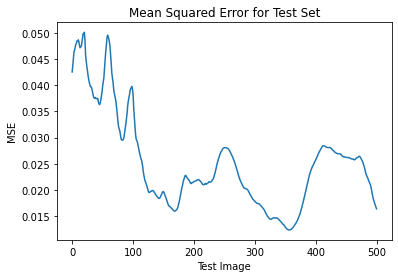

In [32]:
# Calculate the mean squared error between the original and reconstructed images for the test data
mse = np.mean(np.square(u_all_test - reconstructed_images), axis=(1, 2, 3))

# Plot the mean squared error for each test image
plt.plot(mse)
plt.title("Mean Squared Error for Test Set")
plt.xlabel("Test Image")
plt.ylabel("MSE")
plt.show()